In [1]:
#load aiida environment and connect to database
from aiida import load_profile
from aiida.orm import computers
profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [2]:
from aiida.orm import load_group, load_node, WorkChainNode
from aiida_kkr.workflows import combine_imps_wc
from aiida_kkr.workflows.kkr_imp import kkr_imp_wc

In [3]:
from aiida_kkr.tools import MultiImpuritiesData
from aiida_kkr.calculations.kkr import KkrCalculation
import pandas as pd
import numpy as np

In [4]:
node_group_3_3_1 = list(load_group(102).nodes)
node_group_3_3_2 = list(load_group(115).nodes)
node_group_3_4_1 = list(load_group(104).nodes)
node_group_3_4_2 = list(load_group(118).nodes)
node_group_3_3_3 = list(load_group(125).nodes)
node_group_3_3_4 = list(load_group(128).nodes)
node_group_3_3_5 = list(load_group(131).nodes)
node_group_3_4_3 = list(load_group(134).nodes)
node_group_3_4_4 = list(load_group(137).nodes)
node_group_3_4_5 = list(load_group(140).nodes)

In [6]:
#test_imp_data_dict = MultiImpuritiesData.ExtractDictMultipleNode(node_group_3_4_2[0:10])
#test_imp_data_dict.AppendDataMultipleNode(node_group_3_4_2[0:10])

#test_data_base = pd.DataFrame(test_imp_data_dict.GetDataDict())
#pd.DataFrame(test_data_base)


In [7]:
#imp_data_dict = MultiImpuritiesData.ExtractDictMultipleNode(node_group_3_3_1)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_1)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_2)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_3)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_4)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_5)

#imp_data_dict.AppendDataMultipleNode(node_group_3_4_1)
#imp_data_dict.AppendDataMultipleNode(node_group_3_4_2)
#imp_data_dict.AppendDataMultipleNode(node_group_3_4_3)
#imp_data_dict.AppendDataMultipleNode(node_group_3_4_4)
#imp_data_dict.AppendDataMultipleNode(node_group_3_4_5)

#pd_data = pd.DataFrame(imp_data_dict.GetDataDict())
#pd_data.to_csv('d_block_magnetic_data.csv', index=False)

pd_data = pd.read_csv('d_block_magnetic_data.csv')

In [8]:
import seaborn as sns
pd_data.columns.values

array(['calc_imps', 'J_data_uuid', 'imp0', 'offset0', 'ilayer0', 'imp1',
       'offset1', 'ilayer1', 'i', 'j', 'Z_i', 'Z_j', 'J', 'D', 'Dx', 'Dy',
       'Dz', 'rx', 'ry', 'rz', 'r', 'mom1', 'mom2', 'tot_mom'],
      dtype=object)

In [30]:
df_ml = pd_data.drop(['calc_imps', 'J_data_uuid', 'imp0', 'offset0', 'offset1', 'ilayer0', 'ilayer1', 
                      'imp1', 'i', 'j', 'tot_mom', 'D', 'Dx', 'Dy', 'Dz', 'rx', 'ry', 'rz', 'mom1', 'mom2'], axis = 1)

#output data
out_label = 'J'
y = df_ml[out_label].values
X = df_ml.drop(out_label, axis=1)


**Using the linear regression model from scikit-learn**

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lr = LinearRegression()

lr.fit(X,y)

np.sqrt(mean_squared_error(y_true=y, y_pred=lr.predict(X)))
print('len(y) : ', len(y))

len(y) :  2080


In [11]:
from sklearn.model_selection import KFold, cross_val_score

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=crossvalidation, n_jobs=1)

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean R2: 0.009
Folds: 10, mean RMSE: 3.413


In [27]:
(cross_val_predict(lr, X, y, cv=crossvalidation))

array([-0.25380181,  0.04432046, -0.01895485, ...,  0.63216535,
        0.58981969,  0.58325603])

In [29]:
from figrecipes import PlotlyFig
from sklearn.model_selection import cross_val_predict

pf = PlotlyFig(x_title='DFT (MP) bulk modulus (GPa)',
               y_title='Predicted bulk modulus (GPa)',
               title='Linear regression',
               mode='notebook',
               filename="lr_regression.html")

#pf.xy(xy_pairs=[(y, cross_val_predict(lr, X, y, cv=crossvalidation)), ([0, 2080], [0, 2080])], 
      labels=[str(i) for i in df_ml['J']],
      modes=['markers', 'lines'],
      lines=[{}, {'color': 'black', 'dash': 'dash'}], 
      showlegends=False
     )

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 15)

In [149]:
node_ = load_node(108097)
from aiida_kkr.workflows import kkr_imp_sub_wc
from aiida_kkr.calculations import KkrimpCalculation

node__ = node_.get_outgoing(node_class=kkr_imp_sub_wc).all()[0].node
#node_.outputs.last_calc_output_parameters.get_dict()['magnetism_group']['spin_moment_per_atom'][15]
out = node__.get_outgoing(node_class=KkrimpCalculation).all()[0].node.outputs
print(node_?)# .inputs.impurity1_output_node1)

SyntaxError: invalid syntax (3121427386.py, line 8)

In [127]:
node_ = load_node('b3bf4d4b-d903-4afd-8f28-9cdca390bc40')
node_.get_incoming(node_class = combine_imps_wc).all()[0].node

<WorkChainNode: uuid: e8d44d74-8cb3-4e2b-ab6e-9b40279e0585 (pk: 108097) (aiida_kkr.workflows._combine_imps.combine_imps_wc)>

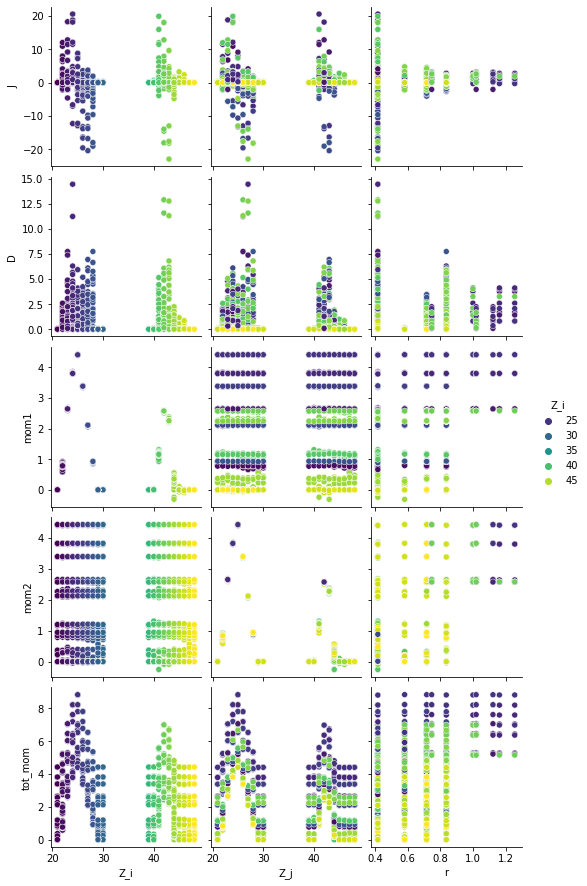

In [45]:
# sns.pairplot(pd_data, vars=['Z_i', 'Z_j', 'J', 'D', 'r', 'mom1', 'mom2', 'tot_mom'])
sns.pairplot(pd_data, x_vars=['Z_i', 'Z_j', 'r'], y_vars=['J', 'D', 'mom1', 'mom2', 'tot_mom'], hue='Z_i', palette='viridis')

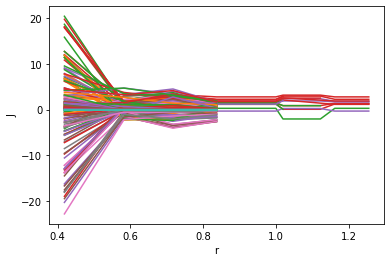

In [50]:
from matplotlib.pyplot import plot
for Zi in set(pd_data['Z_i']):
    for Zj in set(pd_data['Z_j']):
        pd_data1 = pd_data[pd_data['Z_i']==Zi]
        pd_data1 = pd_data1[pd_data1['Z_j']==Zj]
        sns.lineplot(x=pd_data1['r'], y=pd_data1['J'])

In [54]:
from test_ImpurityDataExtraction import test_ImpurityDataExtraction



In [36]:
pd_data.describe()


,imp0,offset0,ilayer0,imp1,offset1,ilayer1,i,j,Z_i,Z_j,...,Dx,Dy,Dz,rx,ry,rz,r,mom1,mom2,tot_mom
count,2080.000000,2080.0,2080.0,2080.000000,2080.000000,2080.000000,2080.0,2080.0,2080.000000,2080.000000,...,2.080000e+03,2.080000e+03,2.080000e+03,2080.000000,2080.000000,2080.000000,2080.000000,2.080000e+03,2.080000e+03,2080.000000
mean,34.208173,0.0,3.0,34.275962,1.491346,3.404808,0.0,1.0,34.208173,34.275962,...,-1.741974e-02,-4.224602e-02,8.277516e-02,-0.426563,-0.001162,0.226357,0.610502,1.295919e+00,1.300714e+00,2.596633
std,9.479957,0.0,0.0,9.462302,0.686517,0.490973,0.0,0.0,9.479957,9.462302,...,4.788119e-01,8.823725e-01,1.353044e+00,0.278440,0.019072,0.308945,0.183726,1.483592e+00,1.487759e+00,2.181753
min,21.000000,0.0,3.0,21.000000,1.000000,3.000000,0.0,1.0,21.000000,21.000000,...,-4.119694e+00,-5.244082e+00,-7.671586e+00,-1.255545,-0.120815,-0.970369,0.418515,-3.107116e-01,-2.547106e-01,-0.000046
25%,25.000000,0.0,3.0,25.000000,1.000000,3.000000,0.0,1.0,25.000000,25.000000,...,-1.092709e-03,-1.400131e-02,-7.648394e-03,-0.418515,0.000000,0.000000,0.418515,-1.936074e-11,-7.571721e-13,0.744686
50%,30.000000,0.0,3.0,30.000000,1.000000,3.000000,0.0,1.0,30.000000,30.000000,...,-3.110724e-24,-3.298217e-08,-4.591737e-22,-0.418515,0.000000,0.000000,0.582221,7.759869e-01,8.004839e-01,2.427369
75%,43.000000,0.0,3.0,43.000000,2.000000,4.000000,0.0,1.0,43.000000,43.000000,...,1.145664e-03,2.965544e-05,1.450853e-04,-0.418515,0.000000,0.582221,0.717033,2.573318e+00,2.574011e+00,3.939749
max,48.000000,0.0,3.0,48.000000,5.000000,4.000000,0.0,1.0,48.000000,48.000000,...,3.109705e+00,5.480468e+00,1.399962e+01,0.209257,0.120815,0.970369,1.255545,4.423477e+00,4.432922e+00,8.843245


In [27]:
imp_atom = (24, 25)
ils = ()
header = list(pd_data.columns)
z_J_r = pd_data[header[1:3] + header[4:6] + header[8:10] + [header[10]] + [header[18]]]
J_Cr_V = z_J_r.loc[(z_J_r['Z_i']==imp_atom[0]) & (z_J_r['Z_j']==imp_atom[1]) & (z_J_r['ilayer0'].isin([3])) & (z_J_r['ilayer1']).isin([3])]
np.array(J_Cr_V.drop_duplicates().loc[:, ['r', 'J']])


array([[0.41851489, 4.7726718 ],
       [0.83702979, 1.82424207],
       [1.        , 1.82424209],
       [1.16202815, 1.82424209],
       [1.25554468, 1.82424209]])

In [21]:
J_Cr_V

,offset0,ilayer0,offset1,ilayer1,Z_i,Z_j,J,r
59,0,3,1,3,24,25,4.772672,0.418515
460,0,3,1,3,24,25,4.772672,0.418515
866,0,3,2,3,24,25,1.824242,0.837030
1208,0,3,3,3,24,25,1.824242,1.000000
1223,0,3,4,3,24,25,1.824242,1.162028
1233,0,3,5,3,24,25,1.824242,1.255545


In [22]:
pd_data.iloc[[1299,1700]]

,imp0,offset0,ilayer0,imp1,offset1,ilayer1,i,j,Z_i,Z_j,...,Dx,Dy,Dz,rx,ry,rz,r,mom1,mom2,tot_mom
1299,24,0,3,25,1,4,0,1,24,25,...,-0.003998,0.005174,0.000261,0.000000,0.0,0.582221,0.582221,3.819087,4.431686,8.250773
1700,24,0,3,25,2,4,0,1,24,25,...,-1.659516,0.311712,-0.786239,-0.418515,0.0,0.582221,0.717033,3.795497,4.428233,8.223730


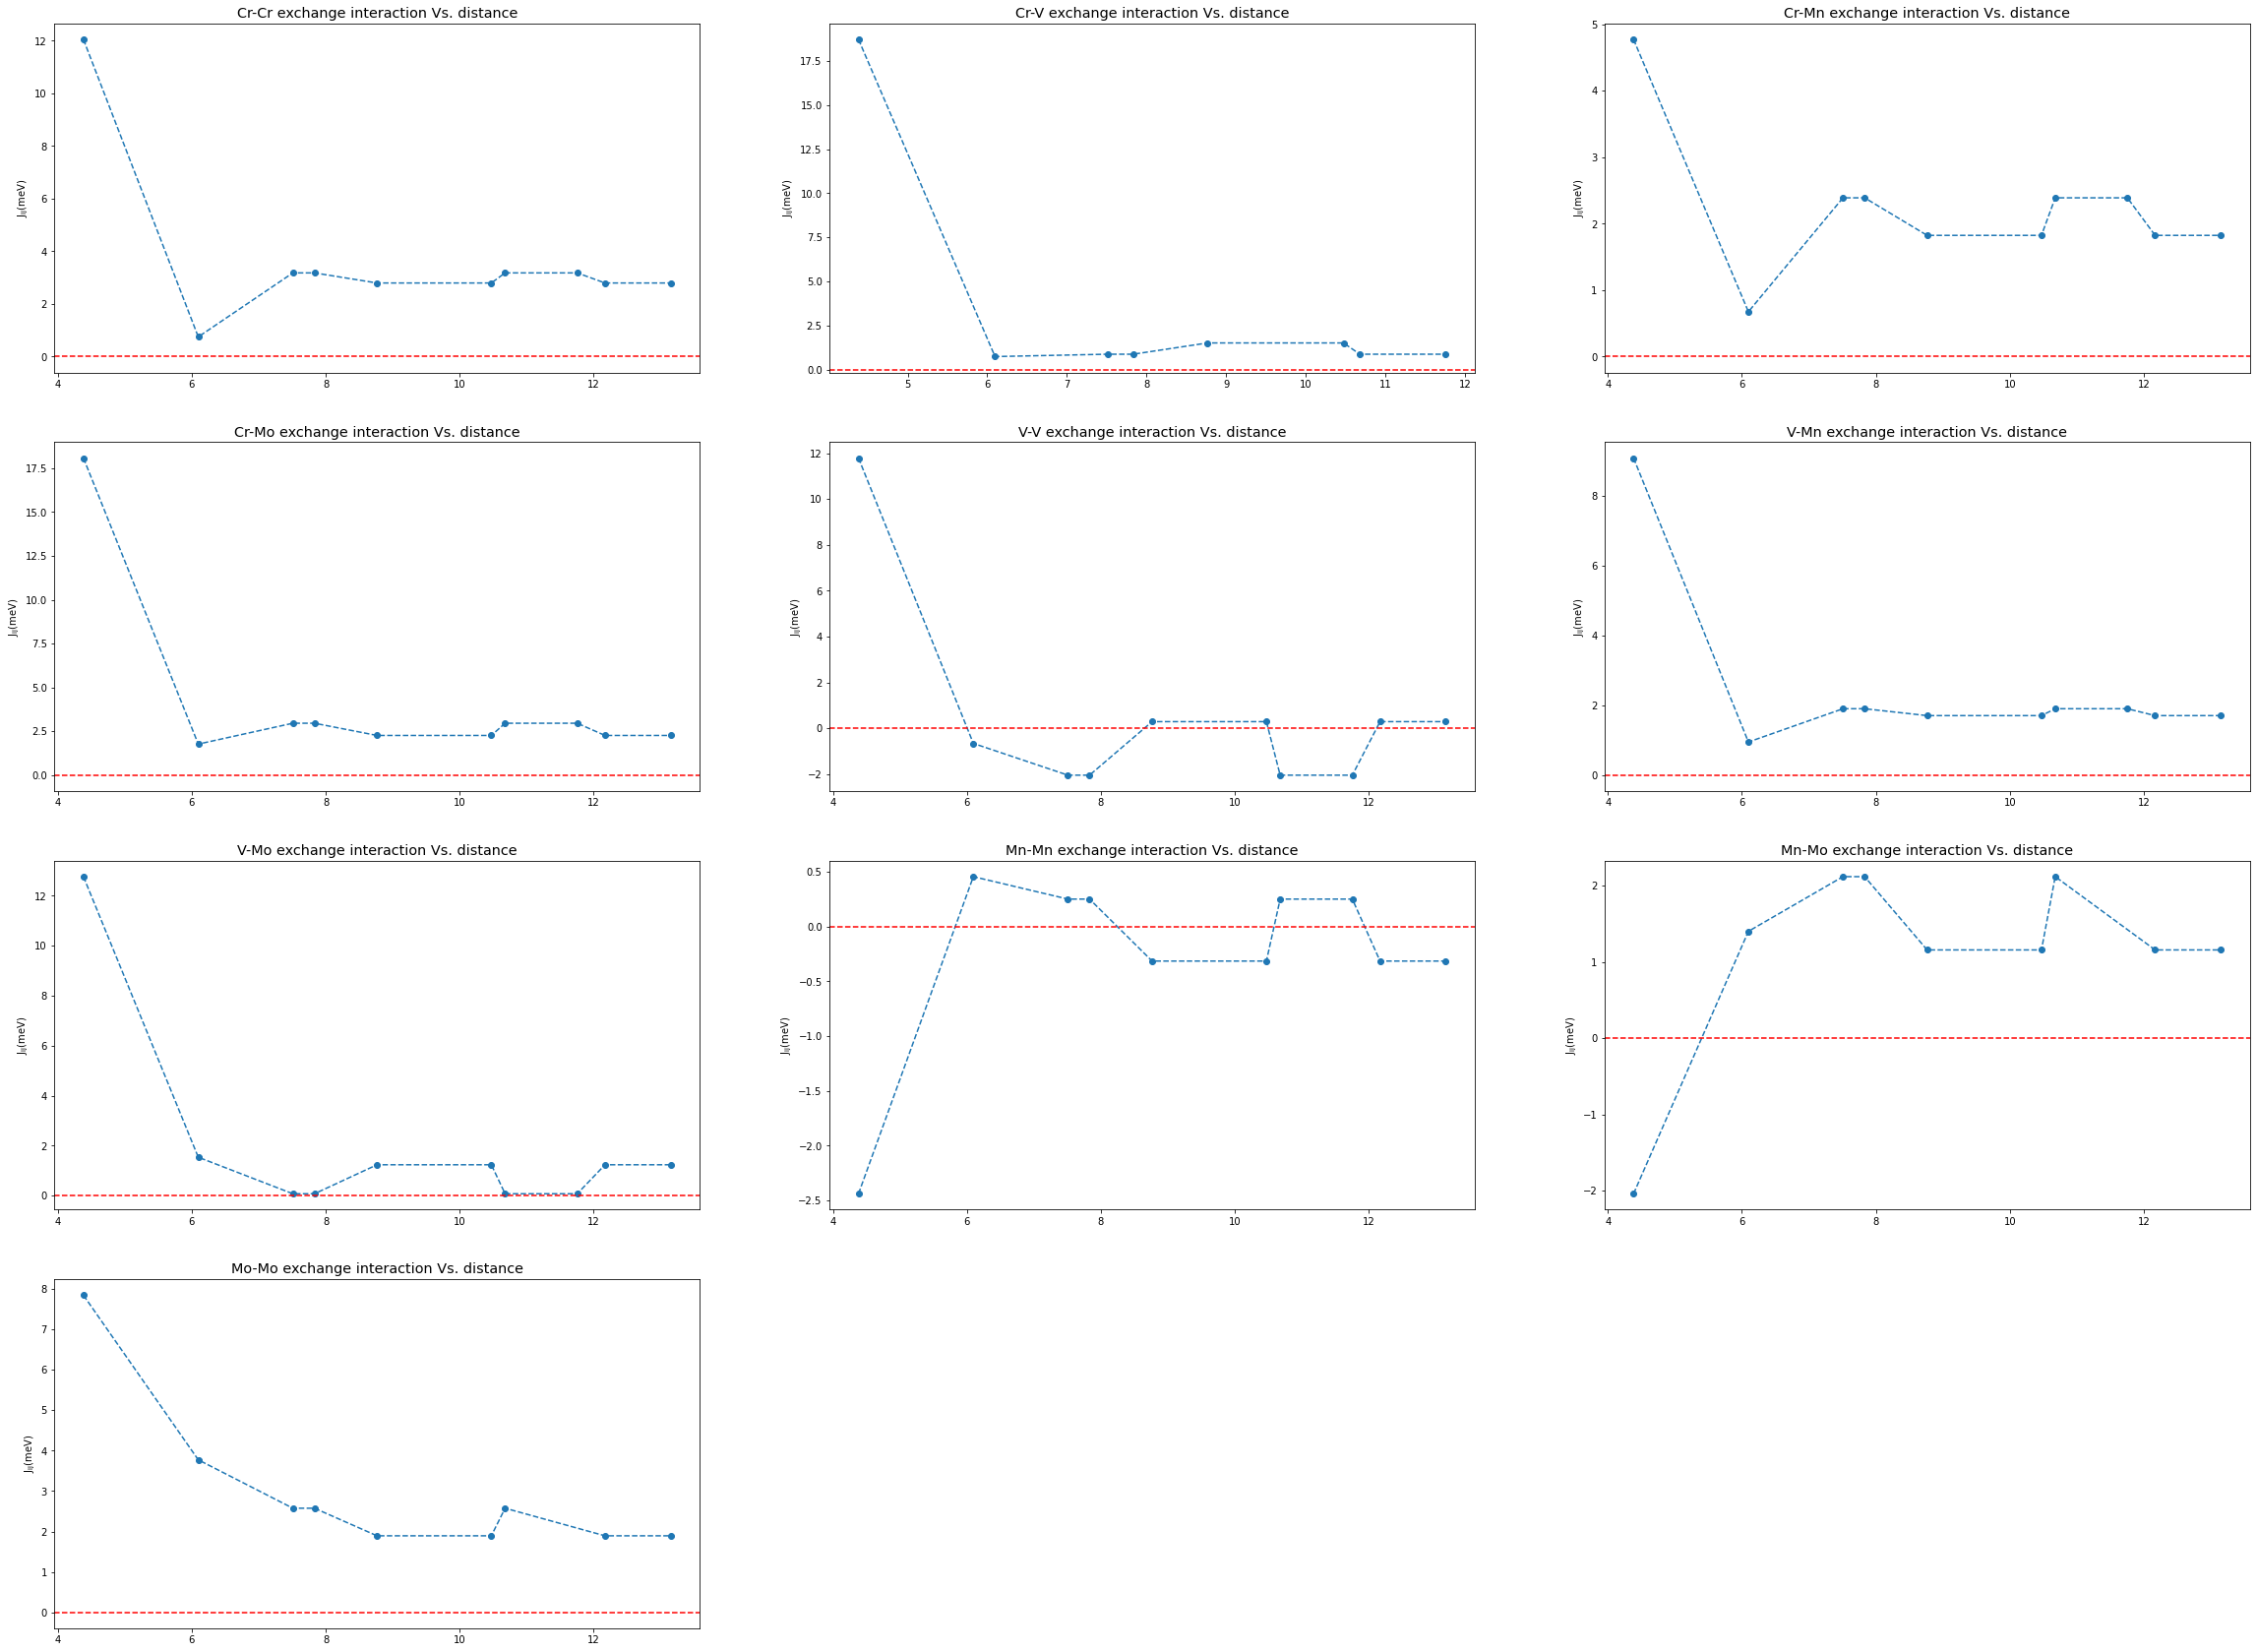

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

pd_data = pd.read_csv('d_block_magnetic_data.csv')
imp_atom = [[(24, 24),('Cr','Cr')], [(24, 23),('Cr','V')], [(24, 25),('Cr','Mn')], [(24, 42),('Cr','Mo')],
            [(23, 23),('V','V')], [(23, 25),('V','Mn')], [(23, 42),('V','Mo')],
            [(25, 25),('Mn','Mn')], [(25, 42),('Mn','Mo')],
            [(42, 42),('Mo','Mo')]]
plt.figure(figsize=(40,30))
x_subplot = 3
y_subplot = 4
dis_unit = 10.4726

for num, Zimp_truple in enumerate(imp_atom):
    imp_atoms = Zimp_truple[0]
    headers = list(pd_data.columns)
    z_J_r = pd_data[headers[8:10] + [headers[10]] + [headers[18]]]
    J_Cr_V = z_J_r.loc[(z_J_r['Z_i']==imp_atoms[0]) & (z_J_r['Z_j']==imp_atoms[1]) ]
    r_vs_J = np.array(J_Cr_V.drop_duplicates().loc[:, ['r', 'J']].sort_values(by='r'))
 #   print(Zimp_truple[1])
 #   print(r_vs_J)
    
    plt.subplot(y_subplot, x_subplot, num+1)
    plt.plot(r_vs_J[:,0]*dis_unit, r_vs_J[:,1], '--o')
    title = (str(Zimp_truple[1][0]) + '-' + str(Zimp_truple[1][1]) + 
            ' exchange interaction Vs. distance')
    plt.title(title, fontsize='x-large')
    plt.axhline(0, ls='--', color= 'red')
    plt.ylabel('$\mathrm{J_{ij}}$(meV)')
    #plt.xlabel()
  #  print(int(num/y_subplot)+1, num%x_subplot+1, num+1)

In [116]:
:int(4/3)

1

In [13]:
group_102 = list(load_group(115).nodes)
for i in group_102[2:5]:
    print(i.uuid)

f53c729d-df31-4b37-b8b0-28b313b95af3
9904cc5f-fa09-4752-ad4c-579839e09c69
e596fb38-eef3-4975-b040-737b797f050e


In [150]:
import aiida_kkr.tests.dbsetup import import_with_migration

SyntaxError: invalid syntax (4062709859.py, line 1)

In [152]:
from aiida.orm import groups

In [155]:
group_143 = load_group(143)
for i in list(group_143.nodes):
    print(i.uuid)

967ecb19-75b9-4f72-9ef8-04da8b7376f0
f3669dc2-a94d-4eee-962e-2720dcd444cd
cc2de321-52ce-482d-962d-76bbf0ed7d84
22d72273-676a-4243-9d41-f20273d7941b
5f8bf3a8-fc7d-45d5-8140-9a1e7f566207
7ce9e9dc-3891-4922-88ae-0a63e5893026


In [174]:
import aiida_kkr.tests.tools.test_multi_imps_data_extract as tools


ModuleNotFoundError: No module named 'multi_imps_data_extract'

In [176]:
pwd

'/Users/mozumder/JupyterHub/Daily_Work_bin'